# GPU timing for POP tracer Laplacians

This notebook repeats some of the CPU tests from [this notebook](https://github.com/ocean-eddy-cpt/gcm-filters-paper/blob/main/POP_tripolar_grid_Laplacian.ipynb) on a GPU.

In [1]:
import gcm_filters
import numpy as np
import cupy as cp
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt

### POP data

Open the POP 0.1 degree data that Ian saved.

In [2]:
ds = xr.open_dataset('/glade/work/igrooms/current_data', decode_times=False)

These are the important dimensions of our dataset:

In [3]:
Nt = np.size(ds.time)
Nz = np.size(ds.z_t)
Ny = np.size(ds.nlat)
Nx = np.size(ds.nlon)
print('Nt = %i, Nz = %i, Nx = %i, Ny = %i' %(Nt,Nz,Nx,Ny))

Nt = 1, Nz = 62, Nx = 3600, Ny = 2400


### Preparing the necessary grid information

The `POP_SIMPLE_TRIPOLAR_T_GRID` Laplacian only needs a `wet_mask` as a grid variable:

In [4]:
gcm_filters.required_grid_vars(gcm_filters.GridType.POP_SIMPLE_TRIPOLAR_T_GRID)

['wet_mask']

So let's create the `wet_mask`. This is a mask that takes 1's on ocean T-cells, and 0's on land T-cells.

In [5]:
wet_mask = xr.where(ds['KMT']>0,1,0)

Text(0.5, 1.0, 'wet_mask')

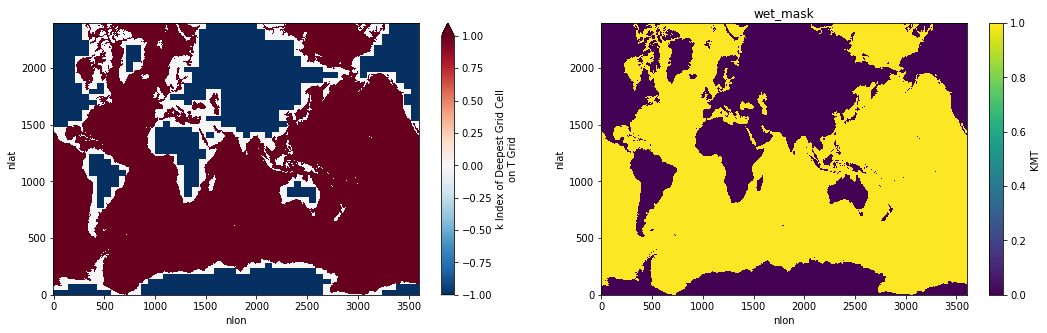

In [6]:
fig,axs = plt.subplots(1,2,figsize=(18,5))
ds.KMT.plot(ax=axs[0],vmin=ds.KMT.min())
wet_mask.plot(ax=axs[1])
axs[1].set_title('wet_mask')

The `POP_TRIPOLAR_T_GRID` Laplacian needs a few more grid variables:

In [7]:
gcm_filters.required_grid_vars(gcm_filters.GridType.POP_TRIPOLAR_T_GRID)

['wet_mask', 'dxe', 'dye', 'dxn', 'dyn', 'tarea']

In [8]:
dxe = ds.HUS.where(wet_mask)/100  # x-spacing centered at eastern T-cell edge in m
dye = ds.HTE.where(wet_mask)/100  # y-spacing centered at eastern T-cell edge in m
dxn = ds.HTN.where(wet_mask)/100  # x-spacing centered at northern T-cell edge in m
dyn = ds.HUW.where(wet_mask)/100  # y-spacing centered at northern T-cell edge in m
tarea = ds.TAREA.where(wet_mask)/10000  # cell area

The filter with fixed filter length scale will have to know what the minimum grid spacing is in our model: about 2.2 km

In [9]:
dx_min_POP = min(dxe.min(),dye.min(),dxn.min(),dyn.min())
dx_min_POP = dx_min_POP.values
dx_min_POP

array(2245.78304344)

### Map NumPy blocks to CuPy blocks

To take advantage of parallel lazy computation, we need to chunk up all our input arrays and turn them into Dask arrays:

In [10]:
wet_mask = wet_mask.chunk({'nlat': Ny, 'nlon': Nx})  # 1 chunk
wet_mask.data = wet_mask.data.map_blocks(cp.asarray)
wet_mask

<xarray.DataArray 'KMT' (nlat: 2400, nlon: 3600)>
dask.array<asarray, shape=(2400, 3600), dtype=int64, chunksize=(2400, 3600), chunktype=cupy.ndarray>
Coordinates:
    ULONG    (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ULAT     (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon

In [11]:
dxe = dxe.chunk({'nlat': Ny, 'nlon': Nx})  # 1 chunk
dxe.data = dxe.data.map_blocks(cp.asarray)

dye = dye.chunk({'nlat': Ny, 'nlon': Nx})  # 1 chunk
dye.data = dye.data.map_blocks(cp.asarray)

dxn = dxn.chunk({'nlat': Ny, 'nlon': Nx})  # 1 chunk
dxn.data = dxn.data.map_blocks(cp.asarray)

dyn = dyn.chunk({'nlat': Ny, 'nlon': Nx})  # 1 chunk
dyn.data = dyn.data.map_blocks(cp.asarray)

tarea = tarea.chunk({'nlat': Ny, 'nlon': Nx})  # 1 chunk
tarea.data = tarea.data.map_blocks(cp.asarray)

### Creating the 2 filters to be compared

First, we create a filter with **fixed coarsening factor**: `filter_scale = 10`. That is, we attempt to remove scales smaller than 10 times the local grid scale. Note that the local grid scale is varying in space, but nomially 0.1 degree.
Moreover, we choose a Gaussian filter shape and 9 Laplacian steps.

In [12]:
filter_scale = 10
n_steps = 9
filter_shape = gcm_filters.FilterShape.GAUSSIAN

In [13]:
filter_simple_pop_tripolar_grid = gcm_filters.Filter(
    filter_scale=filter_scale,
    dx_min=1,
    filter_shape=filter_shape,
    n_steps=n_steps,
    grid_type=gcm_filters.GridType.POP_SIMPLE_TRIPOLAR_T_GRID,
    grid_vars={'wet_mask': wet_mask}
)
filter_simple_pop_tripolar_grid

Filter(filter_scale=10, dx_min=1, filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=9, grid_type=<GridType.POP_SIMPLE_TRIPOLAR_T_GRID: 4>)

The filter is for filtering with **fixed length scale**. We pick a filter length scale of **111.7 km**, equal to one degree of latitude. That is, we attempt to remove scales smaller than 111.7 km.

In [14]:
filter_scale = 111700 
filter_shape = gcm_filters.FilterShape.GAUSSIAN

In [15]:
filter_pop_tripolar_grid = gcm_filters.Filter(
    filter_scale=filter_scale,
    dx_min=dx_min_POP,
    filter_shape=filter_shape,
    n_steps=0,  # default number of steps
    grid_type=gcm_filters.GridType.POP_TRIPOLAR_T_GRID,
    grid_vars={'wet_mask': wet_mask, 'dxe': dxe, 'dye': dye, 'dxn': dxn, 'dyn': dyn, 'tarea': tarea}
)
filter_pop_tripolar_grid

Filter(filter_scale=111700, dx_min=array(2245.78304344), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=0, grid_type=<GridType.POP_TRIPOLAR_T_GRID: 5>)

In the last filter, we chose `n_steps` to be the default number of Laplacian steps, equal to `n_steps=90`.

## Comparing the timing of the 2 filters

We will compare the timing of the 5 Laplacians and filters on different levels of the code on GPU. We will go from high-level to low-level routines.

### High-level routines using Dask

We will time the filtering of
* 1 level of temperature data (`SST`), 
* 62 levels of temperature data (`TEMP`),

for all 5 filters that we created above.

In [16]:
SST = ds.TEMP.isel(z_t=0)
SST = SST.chunk({'nlat': Ny, 'nlon': Nx})  # 1 chunk
SST.data = SST.data.map_blocks(cp.asarray)
SST

<xarray.DataArray 'TEMP' (time: 1, nlat: 2400, nlon: 3600)>
dask.array<asarray, shape=(1, 2400, 3600), dtype=float32, chunksize=(1, 2400, 3600), chunktype=cupy.ndarray>
Coordinates:
  * time     (time) float64 1.238e+04
    z_t      float32 500.0
    ULONG    (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ULAT     (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Potential Temperature
    units:         degC
    grid_loc:      3111
    cell_methods:  time: mean

In [17]:
TEMP = ds.TEMP.chunk({'z_t': 1})  # 62 chunks
TEMP.data = TEMP.data.map_blocks(cp.asarray)
TEMP

<xarray.DataArray 'TEMP' (time: 1, z_t: 62, nlat: 2400, nlon: 3600)>
dask.array<asarray, shape=(1, 62, 2400, 3600), dtype=float32, chunksize=(1, 1, 2400, 3600), chunktype=cupy.ndarray>
Coordinates:
  * time     (time) float64 1.238e+04
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.625e+05 5.875e+05
    ULONG    (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ULAT     (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Potential Temperature
    units:         degC
    grid_loc:      3111
    cell_methods:  time: mean

### `SST`

`POP_SIMPLE_TRIPOLAR_T_GRID, n_steps=9`

In [18]:
%time SST_filtered_simple_pop_tripolar_grid = filter_simple_pop_tripolar_grid.apply(SST, dims=['nlat', 'nlon'])

CPU times: user 1.66 s, sys: 342 ms, total: 2 s
Wall time: 2 s


In [19]:
%time SST_filtered_simple_pop_tripolar_grid_computed = SST_filtered_simple_pop_tripolar_grid.compute()  # triggering computation

CPU times: user 238 ms, sys: 149 ms, total: 387 ms
Wall time: 306 ms


`POP_TRIPOLAR_T_GRID`

`n_steps=90`

In [20]:
%time SST_filtered_pop_tripolar_grid = filter_pop_tripolar_grid.apply(SST, dims=['nlat', 'nlon'])

CPU times: user 1.14 s, sys: 179 ms, total: 1.32 s
Wall time: 1.32 s


In [21]:
%time SST_filtered_pop_tripolar_grid_computed = SST_filtered_pop_tripolar_grid.compute()  # triggering computation

CPU times: user 466 ms, sys: 256 ms, total: 722 ms
Wall time: 568 ms


### `TEMP`

`POP_SIMPLE_TRIPOLAR_T_GRID`

In [22]:
%time TEMP_filtered_simple_pop_tripolar_grid = filter_simple_pop_tripolar_grid.apply(TEMP, dims=['nlat', 'nlon'])

CPU times: user 1.64 s, sys: 384 ms, total: 2.03 s
Wall time: 2.02 s


In [23]:
%time TEMP_filtered_simple_pop_tripolar_grid_computed = TEMP_filtered_simple_pop_tripolar_grid.compute()  # triggering computation

CPU times: user 7.52 s, sys: 1.67 s, total: 9.19 s
Wall time: 5.45 s


`POP_TRIPOLAR_T_GRID`

`n_steps=90`

In [24]:
%time TEMP_filtered_pop_tripolar_grid = filter_pop_tripolar_grid.apply(TEMP, dims=['nlat', 'nlon'])

CPU times: user 1.17 s, sys: 157 ms, total: 1.33 s
Wall time: 1.33 s


In [25]:
%time TEMP_filtered_pop_tripolar_grid_computed = TEMP_filtered_pop_tripolar_grid.compute()  # triggering computation

CPU times: user 23.3 s, sys: 9.56 s, total: 32.8 s
Wall time: 22.5 s


The numbers above include the time to load the data from disk. Therefore, we measure how long the **loading of the data** takes:

In [26]:
%time SST_computed = SST.compute()

CPU times: user 498 ms, sys: 204 ms, total: 701 ms
Wall time: 1.17 s


In [27]:
%time TEMP_computed = TEMP.compute()

CPU times: user 6.9 s, sys: 1.74 s, total: 8.64 s
Wall time: 6.18 s
